In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.show()

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [8]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

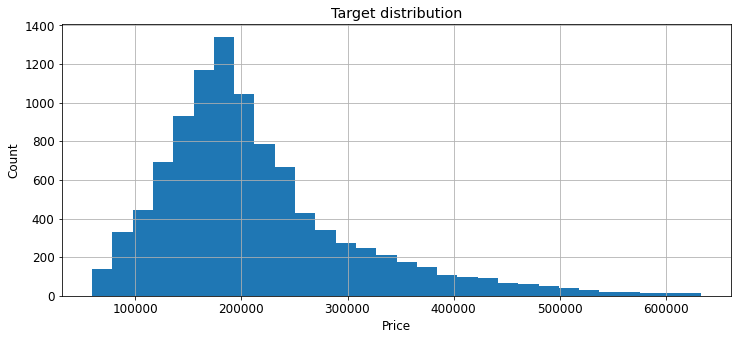

In [9]:
plt.figure(figsize = (12, 5))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [10]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [11]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [12]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [13]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [14]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [15]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [16]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [17]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [18]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [19]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [20]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [5]:
train_df = pd.read_pickle('prepared.pkl')

In [12]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,price_per_sqrm
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,851,1,213530.788443,5,1,161974.797753,2651.708272
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,2,2,192736.759561,4462.045990
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,3,0,207856.713420,3600.596698
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,0,0,1,652,1,146735.671740,2,3,183157.462451,4160.019670
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,89,0,201584.441255,2,4,171739.199220,5351.088794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,0,0,0,118,1,232514.855623,3,0,207856.713420,2431.568231
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,0,1,0,851,1,165683.084779,2,3,183157.462451,3105.618729
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,0,0,0,7,0,165953.912580,2,0,180278.555985,5597.463388
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,0,0,0,165,1,153921.400690,2,0,180278.555985,5315.213665


In [6]:
train_df['price_per_sqrm'] = train_df.Price / train_df.Square

In [13]:
dists = train_df.groupby('DistrictId', as_index=False).agg({'price_per_sqrm': [('min_price', 'min'), ('max_price', 'max'), ('mean_price', 'mean')], 'HouseYear': [('avg_house_age', 'mean')]})

In [14]:
dists.describe()

price_per_sqrm                                 HouseYear
           min_price      max_price   mean_price avg_house_age
count     205.000000     205.000000   205.000000    205.000000
mean     2547.086455   10612.313195  4852.068324   1976.923682
std      1581.459205   23654.584662  1085.677974     14.057434
min       208.293451    3214.414881  2284.108677   1924.500000
25%      1361.980166    5570.011968  4176.437542   1968.888889
50%      1950.704206    6319.711365  4666.270073   1978.310924
75%      3581.146784    7321.975925  5416.762429   1986.265734
max      8268.740559  230463.537966  9452.113505   2007.000000

In [15]:
dists.columns

MultiIndex([(    'DistrictId',              ''),
            ('price_per_sqrm',     'min_price'),
            ('price_per_sqrm',     'max_price'),
            ('price_per_sqrm',    'mean_price'),
            (     'HouseYear', 'avg_house_age')],
           )

In [16]:
X_small = dists[[('price_per_sqrm',  'min_price'),('price_per_sqrm',  'max_price'),('price_per_sqrm', 'mean_price'), ('HouseYear', 'avg_house_age')]]

In [65]:
X_small = dists[[('price_per_sqrm',  'min_price'),('price_per_sqrm',  'max_price'),('price_per_sqrm', 'mean_price')]]

In [66]:
X_small

price_per_sqrm                            
         min_price      max_price   mean_price
0      1397.431260    5309.992743  3710.401014
1      1207.535586  159593.107918  3522.839502
2      1340.074937    5442.505496  4377.498005
3      1475.957373    6682.999484  5093.929852
4      1428.120159    6258.833718  4177.749766
..             ...            ...          ...
200    1252.125439   11164.009578  5552.355469
201    2123.749914    5111.723407  3987.220590
202    1843.028023    6116.863698  4809.095965
203    1770.563840    6029.096383  4307.038776
204    1371.758751    5504.432490  3938.329635

[205 rows x 3 columns]

In [18]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [19]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [20]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [21]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [67]:
scaler = StandardScaler()

colnames = X_small.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_small), columns=colnames)
#X_test_scaled = pd.DataFrame(scaler.transform(dists), columns=colnames)

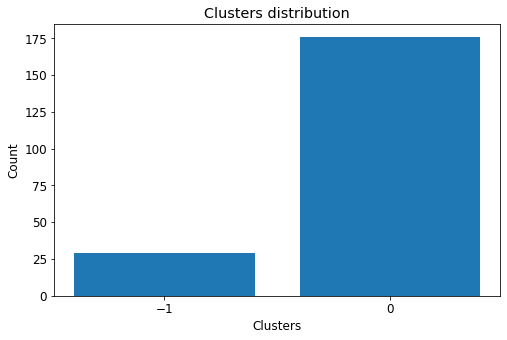

In [68]:
dbscan = DBSCAN(eps=0.45, min_samples=5)
labels_clast = dbscan.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_dbscan')

# labels_clast_test = dbscan.predict(X_test_scaled)
# labels_clast_test = pd.Series(labels_clast_test, name='clusters_dbscan')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [24]:
X_train_scaled

price_per_sqrm                          HouseYear
         min_price max_price mean_price avg_house_age
0        -0.728738 -0.224705  -1.054145      0.598214
1        -0.849108  6.313596  -1.227328      0.601741
2        -0.765095 -0.219089  -0.438189      0.145517
3        -0.678962 -0.166519   0.223320     -0.807502
4        -0.709285 -0.184494  -0.622624     -0.440802
..             ...       ...        ...           ...
200      -0.820844  0.023380   0.646602     -1.368481
201      -0.268343 -0.233107  -0.798547      1.686772
202      -0.446285 -0.190511  -0.039678     -0.764715
203      -0.492219 -0.194230  -0.503247     -0.252635
204      -0.745011 -0.216465  -0.843690     -0.009996

[205 rows x 4 columns]

In [79]:
train_df = pd.read_pickle('prepared.pkl')

In [80]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,1,851,1,213530.788443,5,1,161974.797753
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,2,2,192736.759561
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,3,0,207856.713420
3,2352,1,1.0,40.409907,34.409907,3.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,652,1,146735.671740,2,3,183157.462451
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,2,4,171739.199220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,119367.455796,0,0,0,118,1,232514.855623,3,0,207856.713420
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,199715.148807,0,1,0,851,1,165683.084779,2,3,183157.462451
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,165953.912580,0,0,0,7,0,165953.912580,2,0,180278.555985
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,171842.411855,0,0,0,165,1,153921.400690,2,0,180278.555985


In [81]:
X_train  = train_df.drop(labels=['Price', 'DistrictSize','IsDistrictLarge','MedPriceByDistrict','year_cat','floor_cat','MedPriceByFloorYear'], axis=1)
y_train = train_df['Price']

In [82]:
scaler = StandardScaler()

colnames = X_train.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
#X_test_scaled = pd.DataFrame(scaler.transform(dists), columns=colnames)

In [69]:
X_small

price_per_sqrm                            
         min_price      max_price   mean_price
0      1397.431260    5309.992743  3710.401014
1      1207.535586  159593.107918  3522.839502
2      1340.074937    5442.505496  4377.498005
3      1475.957373    6682.999484  5093.929852
4      1428.120159    6258.833718  4177.749766
..             ...            ...          ...
200    1252.125439   11164.009578  5552.355469
201    2123.749914    5111.723407  3987.220590
202    1843.028023    6116.863698  4809.095965
203    1770.563840    6029.096383  4307.038776
204    1371.758751    5504.432490  3938.329635

[205 rows x 3 columns]

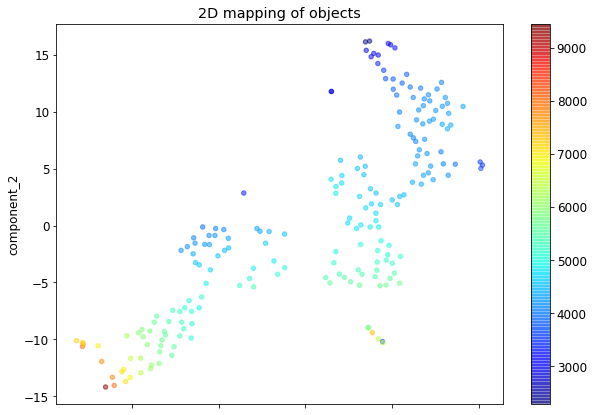

Wall time: 2.91 s


In [94]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=30)
display_components_in_2D_space(components_2d_tsne, X_small[('price_per_sqrm','mean_price')])

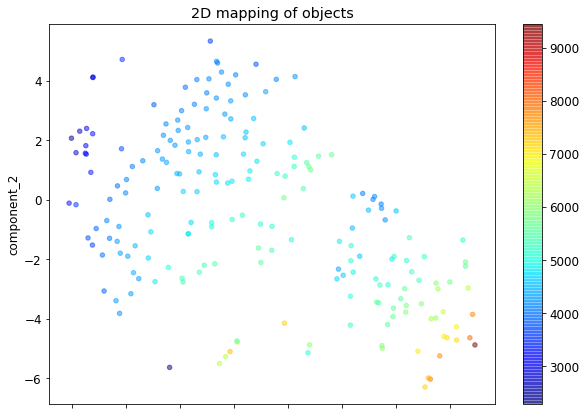

Wall time: 2.64 s


In [27]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=50)
display_components_in_2D_space(components_2d_tsne, X_small[('price_per_sqrm','mean_price')])

In [95]:
components_2d_tsne

,component_1,component_2
0,4.628868,12.909352
1,4.451390,-10.208845
2,8.387110,8.832551
3,4.174905,-2.202759
4,6.413630,9.288862
...,...,...
200,4.890525,-4.649185
201,8.643966,5.387875
202,3.201368,0.049970
203,6.353710,5.416009


In [108]:
model = KMeans(n_clusters=4, random_state=42)

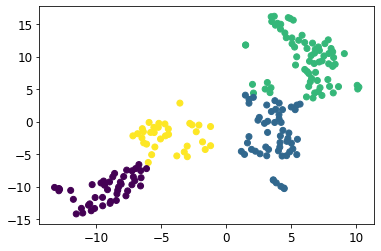

In [109]:
labels_train = model.fit_predict(components_2d_tsne)

plt.scatter(components_2d_tsne['component_1'], components_2d_tsne['component_2'], c=labels_train)

plt.show()

In [139]:
df1 = pd.DataFrame(dists['DistrictId'])

In [141]:
df2 = pd.DataFrame(labels_train, columns=['cluster'])

In [147]:
cdists = pd.concat([df1, df2], axis=1)

In [150]:
cdists.to_pickle('dist_clusters.pkl')

In [159]:

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  object 
 1   DistrictId           10000 non-null  object 
 2   Rooms                10000 non-null  float64
 3   Square               10000 non-null  float64
 4   LifeSquare           10000 non-null  float64
 5   KitchenSquare        10000 non-null  float64
 6   Floor                10000 non-null  int64  
 7   HouseFloor           10000 non-null  float64
 8   HouseYear            10000 non-null  int64  
 9   Ecology_1            10000 non-null  float64
 10  Ecology_2            10000 non-null  int64  
 11  Ecology_3            10000 non-null  int64  
 12  Social_1             10000 non-null  int64  
 13  Social_2             10000 non-null  int64  
 14  Social_3             10000 non-null  int64  
 15  Helthcare_2          10000 non-null  

In [157]:
train_df = pd.merge(train_df, cdists, on='DistrictId')


In [163]:
X_train_large = train_df[['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2','Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan','DistrictSize', 'year_cat', 'floor_cat','cluster', 'price_per_sqrm']]

In [162]:
lr = 